# **Step 1: import the libraries**

In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,accuracy_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Conv2D,MaxPooling2D, Flatten
from imblearn.combine import SMOTETomek ##For upsampling

In [442]:
import pickle #for serialization
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# Step 2: import the **dataset**

In [443]:
dataset=pd.read_csv("Diabetes.csv")

In [444]:
title_mapping = {'YES':1,'NO':0}
dataset[' Class variable']=dataset[' Class variable'].map(title_mapping)

# **Checking how many result we have of each outcome**

Zeros Count in Data

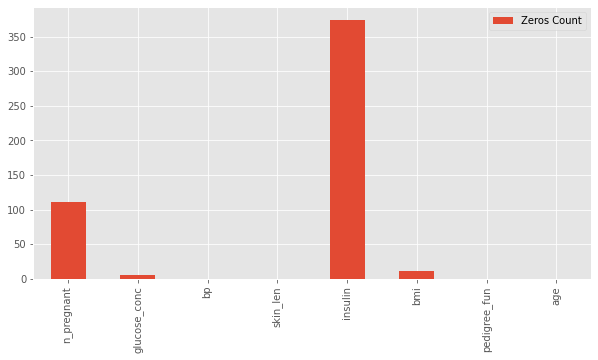

In [445]:
zeros=(X == 0).sum(axis=0)
zeros=pd.DataFrame(zeros)
zeros.columns=['Zeros Count']
# zeros.drop(' Class variable',inplace=True)
zeros.plot(kind='bar',stacked=True, figsize=(10,5),grid=True)

In [446]:
col=['n_pregnant','glucose_conc','bp','skin_len','insulin','bmi','pedigree_fun','age','Output']
dataset.columns=col
dataset.head()

,n_pregnant,glucose_conc,bp,skin_len,insulin,bmi,pedigree_fun,age,Output
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [385]:
diabetes_true_count = len(dataset.loc[dataset['Output'] == True])
diabetes_false_count = len(dataset.loc[dataset['Output'] == False])
(diabetes_true_count,diabetes_false_count)

(268, 500)

# **Data** **Processing**

**Step 3: replace the null values with the respective mean **

In [447]:
col=['glucose_conc','bp','insulin','bmi','skin_len']
for i in col:
    X[i].replace(0, np.nan, inplace= True)
X.isnull().sum()

n_pregnant        0
glucose_conc      5
bp                0
skin_len          0
insulin         374
bmi              11
pedigree_fun      0
age               0
dtype: int64

In [448]:
def median_target(var):   
    temp = dataset[dataset[var].notnull()]
    temp = temp[[var, 'Output']].groupby(['Output'])[[var]].median().reset_index()
    return temp

In [449]:
median_target('glucose_conc')

,Output,glucose_conc
0,0,107.0
1,1,140.0


In [450]:
median_target('bmi')

,Output,bmi
0,0,30.05
1,1,34.25


In [451]:
median_target('bp')

,Output,bp
0,0,70.0
1,1,74.0


In [452]:
median_target('skin_len')

,Output,skin_len
0,0,21.0
1,1,27.0


In [453]:
median_target('insulin')

,Output,insulin
0,0,39.0
1,1,0.0


In [454]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['insulin'].isnull()), 'insulin'] = 102.5
dataset.loc[(dataset['Output'] == 1 ) & (dataset['insulin'].isnull()), 'insulin'] = 169.5
dataset.loc[(dataset['Output'] == 0 ) & (dataset['glucose_conc'].isnull()), 'glucose_conc'] = 107
dataset.loc[(dataset['Output'] == 1 ) & (dataset['glucose_conc'].isnull()), 'glucose_conc'] = 140
dataset.loc[(dataset['Output'] == 0 ) & (dataset['skin_len'].isnull()), 'skin_len'] = 27
dataset.loc[(dataset['Output'] == 1 ) & (dataset['skin_len'].isnull()), 'skin_len'] = 32
dataset.loc[(dataset['Output'] == 0 ) & (dataset['bp'].isnull()), 'bp'] = 70
dataset.loc[(dataset['Output'] == 1 ) & (dataset['bp'].isnull()), 'bp'] = 74.5
dataset.loc[(dataset['Output'] == 0 ) & (dataset['bmi'].isnull()), 'bmi'] = 30.1
dataset.loc[(dataset['Output'] == 1 ) & (dataset['bmi'].isnull()), 'bmi'] = 34.3

**Checking if the null values were replaced**

In [455]:
dataset.isnull().sum()

n_pregnant      0
glucose_conc    0
bp              0
skin_len        0
insulin         0
bmi             0
pedigree_fun    0
age             0
Output          0
dtype: int64

# **Step4: Checking the presence of outliers in the data using BOX PLOT**

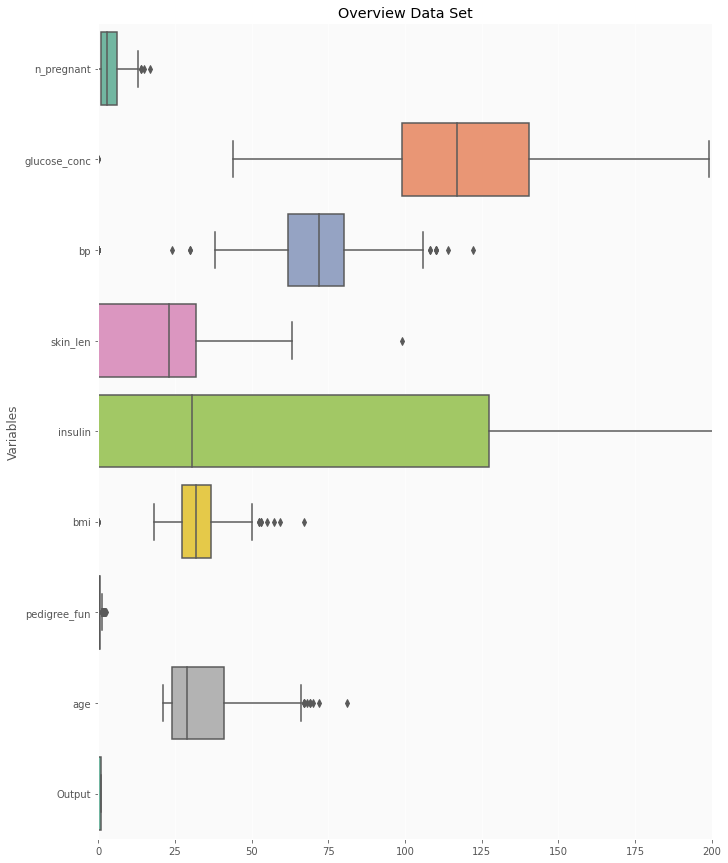

In [456]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = dataset, 
  orient = 'h', 
  palette = 'Set2')

**Correcting the outliers using the median**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


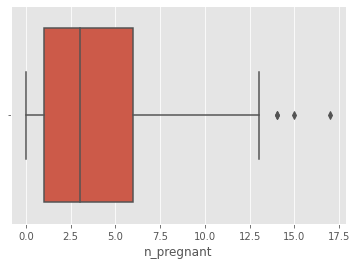

In [457]:
sns.boxplot(dataset.n_pregnant)

In [458]:
dataset['n_pregnant'].value_counts()

1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: n_pregnant, dtype: int64

In [459]:
median_target('n_pregnant')

,Output,n_pregnant
0,0,2.0
1,1,4.0


In [460]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['n_pregnant']>13), 'n_pregnant'] = 2
dataset.loc[(dataset['Output'] == 1 ) & (dataset['n_pregnant']>13), 'n_pregnant'] = 4

In [461]:
dataset['n_pregnant'].value_counts()

1     135
0     111
2     103
3      75
4      72
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
Name: n_pregnant, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


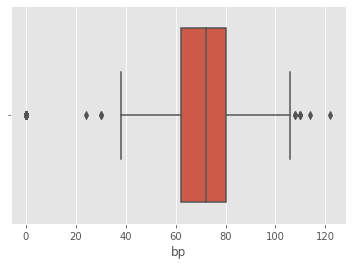

In [462]:
sns.boxplot(dataset.bp)

In [463]:
median_target('bp')

,Output,bp
0,0,70.0
1,1,74.0


In [464]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['bp']<40), 'bp'] = 70
dataset.loc[(dataset['Output'] == 1 ) & (dataset['bp']<40), 'bp'] = 74.5
dataset.loc[(dataset['Output'] == 0 ) & (dataset['bp']>103), 'bp'] = 70
dataset.loc[(dataset['Output'] == 1 ) & (dataset['bp']>103), 'bp'] = 74.5

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


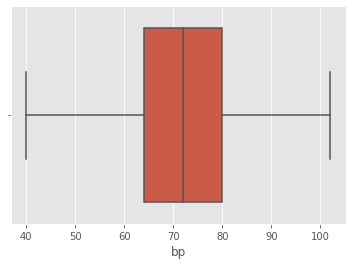

In [465]:
sns.boxplot(dataset.bp)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


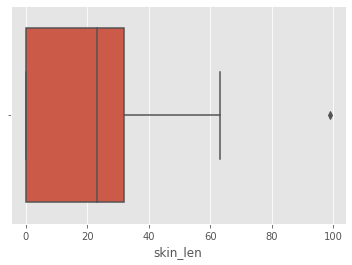

In [466]:
sns.boxplot(dataset.skin_len)

In [467]:
median_target('skin_len')

,Output,skin_len
0,0,21.0
1,1,27.0


In [468]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['skin_len']>38), 'skin_len'] = 27
dataset.loc[(dataset['Output'] == 1 ) & (dataset['skin_len']>38), 'skin_len'] = 32
dataset.loc[(dataset['Output'] == 0 ) & (dataset['skin_len']<20), 'skin_len'] = 27
dataset.loc[(dataset['Output'] == 1 ) & (dataset['skin_len']<20), 'skin_len'] = 32

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


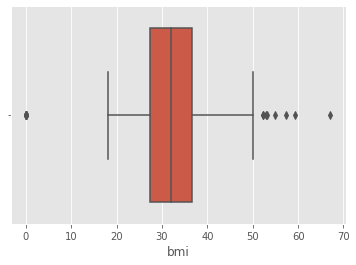

In [469]:
sns.boxplot(dataset.bmi)

In [470]:
median_target('bmi')

,Output,bmi
0,0,30.05
1,1,34.25


In [471]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['bmi']>48), 'bmi'] = 30.1
dataset.loc[(dataset['Output'] == 1 ) & (dataset['bmi']>48), 'bmi'] = 34.3

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


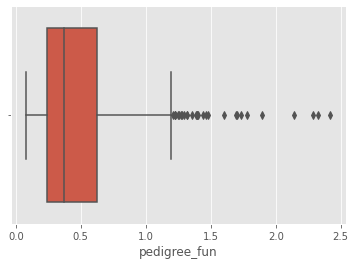

In [472]:
sns.boxplot(dataset.pedigree_fun)

In [473]:
median_target('pedigree_fun')

,Output,pedigree_fun
0,0,0.336
1,1,0.449


In [474]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['pedigree_fun']>1), 'pedigree_fun'] = 0.336
dataset.loc[(dataset['Output'] == 1 ) & (dataset['pedigree_fun']>1), 'pedigree_fun'] = 0.449

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


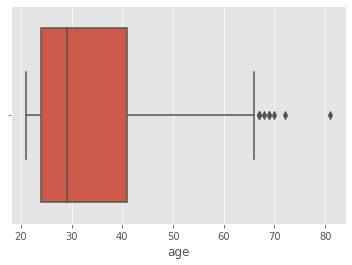

In [475]:
sns.boxplot(dataset.age)

In [476]:
median_target('age')

,Output,age
0,0,27.0
1,1,36.0


In [477]:
dataset.loc[(dataset['Output'] == 0 ) & (dataset['age']>61), 'age'] = 27
dataset.loc[(dataset['Output'] == 1 ) & (dataset['age']>61), 'age'] = 36

# **Step 4 : Splitting the data**

In [492]:
X = dataset.drop(['Output'], 1)
y = dataset['Output']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [493]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [494]:
print(x_train)

     n_pregnant  glucose_conc    bp  skin_len  insulin   bmi  pedigree_fun  \
762           9            89  62.0        27      0.0  22.5         0.142   
127           1           118  58.0        36     94.0  33.3         0.261   
564           0            91  80.0        27      0.0  32.4         0.601   
375          12           140  82.0        32    325.0  39.2         0.528   
663           9           145  80.0        32    130.0  37.9         0.637   
..          ...           ...   ...       ...      ...   ...           ...   
763          10           101  76.0        27    180.0  32.9         0.171   
192           7           159  66.0        32      0.0  30.4         0.383   
629           4            94  65.0        22      0.0  24.7         0.148   
559          11            85  74.0        27      0.0  30.1         0.300   
684           5           136  82.0        27      0.0   0.0         0.640   

     age  
762   33  
127   23  
564   27  
375   58  
663   40

In [495]:
print(y_train)

762    0
127    0
564    0
375    1
663    1
      ..
763    0
192    1
629    0
559    0
684    0
Name: Output, Length: 576, dtype: int64


# **Support Vector Machine with Radial Basis Function Kernel**

In [496]:
model=SVC(kernel='rbf')
model.fit(x_train,y_train)

SVC()

In [335]:
y_pred=model.predict(x_test)

In [336]:
accuracy_score(y_test,y_pred)

0.8831168831168831

In [337]:
confusion_matrix(y_test,y_pred)

array([[93, 14],
       [ 4, 43]])

In [338]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       107
           1       0.75      0.91      0.83        47

    accuracy                           0.88       154
   macro avg       0.86      0.89      0.87       154
weighted avg       0.90      0.88      0.89       154



# **Random Forest Classifier**

In [497]:
classifier=RandomForestClassifier()
x_train = x_train.values
classifier.fit(x_train,y_train)

RandomForestClassifier()

In [498]:
Y_pred=classifier.predict(x_test)
confusion_matrix(y_test,Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[119,  11],
       [  4,  58]])

In [499]:
accuracy_score(y_test,Y_pred)

0.921875

In [500]:
print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       130
           1       0.84      0.94      0.89        62

    accuracy                           0.92       192
   macro avg       0.90      0.93      0.91       192
weighted avg       0.93      0.92      0.92       192



ROC AUC: 0.93


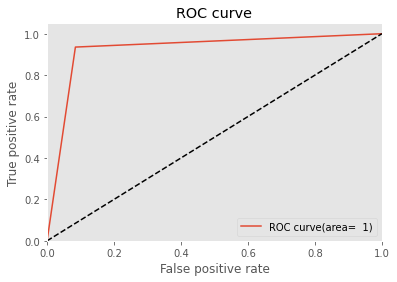

In [501]:
fpr,tpr,_=roc_curve(y_test,Y_pred)
#calculate AUC
roc_auc=auc(fpr,tpr)
print('ROC AUC: %0.2f' % roc_auc)
#plot of ROC curve for a specified class
plt.figure()
plt.plot(fpr,tpr,label='ROC curve(area= %2.f)' %roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [505]:
model_file=open("modelupdated.pkl","wb")##to serialize
pickle.dump(classifier,model_file)
model_file.close()##always remember to close it

# **Decision Tree**

In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions = dtree.predict(x_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_test,predictions)))

Accuracy Score = 0.8636363636363636


# **XGBoost**

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(gamma=0)
xgb_model.fit(x_train, y_train)

XGBClassifier()

In [ ]:
xgb_pred = xgb_model.predict(x_test)
print("Accuracy Score =", format(metrics.accuracy_score(y_test, xgb_pred)))

Accuracy Score = 0.9285714285714286
